# Smart Gift Planner - Holiday Data Jam 2025

**Author:** Viktor  
**Date:** December 2025  
**Project:** Smart Gift Planner Recommender System

## Introduction

This project implements a Smart Gift Planner recommender system designed to help users find personalized gift suggestions based on their specified interests and budget constraints. The system leverages the Amazon Products Dataset, which contains comprehensive product information including titles, descriptions, categories, prices, ratings, and review counts. Our approach begins with thorough data preprocessing to clean and normalize the dataset, followed by the implementation of both baseline and enhanced recommendation models. The baseline model utilizes TF-IDF (Term Frequency-Inverse Document Frequency) vectorization combined with cosine similarity to match user interests with product descriptions. The enhanced model upgrades this approach by incorporating sentence-transformer embeddings for semantic understanding, along with additional ranking signals such as average ratings, review counts, and popularity scores. This multi-faceted approach ensures that recommendations are not only relevant to the user's stated interests but also reflect product quality and community validation. 

The final deliverable includes cleaned datasets, recommender functions, visualizations for SE integration, and JSON outputs ready for mobile app implementation.

## 1: Setup and Imports

In [42]:
import pandas as pd
import numpy as np
import json
import re
import warnings
warnings.filterwarnings('ignore')

# Text processing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Sentence transformers for enhanced model
from sentence_transformers import SentenceTransformer

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go

## 2: Data Loading and Preprocessing

In [43]:
df = pd.read_csv('amazon_products.csv')

print(f"Dataset Shape: {df.shape}")
print(f"Total Products: {len(df):,}")
print(f"\nColumns: {df.columns.tolist()}")

# Data types
print(f"\nData Types:\n{df.dtypes}")

print("\nFirst 10 Rows:")
df.head()

Dataset Shape: (1426337, 11)
Total Products: 1,426,337

Columns: ['asin', 'title', 'imgUrl', 'productURL', 'stars', 'reviews', 'price', 'listPrice', 'category_id', 'isBestSeller', 'boughtInLastMonth']

Data Types:
asin                  object
title                 object
imgUrl                object
productURL            object
stars                float64
reviews                int64
price                float64
listPrice            float64
category_id            int64
isBestSeller            bool
boughtInLastMonth      int64
dtype: object

First 10 Rows:


,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,category_id,isBestSeller,boughtInLastMonth
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,0.00,104,False,2000
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.5,0,169.99,209.99,104,False,1000
2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,https://m.media-amazon.com/images/I/71EA35zvJB...,https://www.amazon.com/dp/B07XSCCZYG,4.6,0,365.49,429.99,104,False,300
3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,https://m.media-amazon.com/images/I/91k6NYLQyI...,https://www.amazon.com/dp/B08MVFKGJM,4.6,0,291.59,354.37,104,False,400
4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,https://m.media-amazon.com/images/I/61NJoaZcP9...,https://www.amazon.com/dp/B01DJLKZBA,4.5,0,174.99,309.99,104,False,400


In [44]:
# Load and merge category names
categories = pd.read_csv('amazon_categories.csv')
df = df.merge(categories, left_on='category_id', right_on='id', how='left')

# Remove redundant ID columns
df = df.drop(columns=['id', 'category_id'])

print(f"Categories merged. Sample:")
print(df[['title', 'category_name']].head())

Categories merged. Sample:
                                               title category_name
0  Sion Softside Expandable Roller Luggage, Black...     Suitcases
1  Luggage Sets Expandable PC+ABS Durable Suitcas...     Suitcases
2  Platinum Elite Softside Expandable Checked Lug...     Suitcases
3  Freeform Hardside Expandable with Double Spinn...     Suitcases
4  Winfield 2 Hardside Expandable Luggage with Sp...     Suitcases


In [45]:
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Missing %': missing_pct})
print(missing_df)

                   Missing Count  Missing %
asin                           0    0.00000
title                          1    0.00007
imgUrl                         0    0.00000
productURL                     0    0.00000
stars                          0    0.00000
reviews                        0    0.00000
price                          0    0.00000
listPrice                      0    0.00000
isBestSeller                   0    0.00000
boughtInLastMonth              0    0.00000
category_name                  0    0.00000


In [46]:
# Cleaning functions
def clean_text(text):
    """Clean and normalize text fields."""
    if pd.isna(text):
        return ''
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [47]:
# Applied preprocessing
print("Applying data cleaning:")

df['title_clean'] = df['title'].apply(clean_text)

# Rename columns to match our model expectations
df['rating'] = df['stars']
df['review_count'] = df['reviews']

# Filter out products with zero/invalid prices
print(f"Products before filtering: {len(df):,}")
df_clean = df[df['price'] > 0].copy()
print(f"Products after removing $0 prices: {len(df_clean):,}")

df_clean.head(5)

Applying data cleaning:
Products before filtering: 1,426,337
Products after removing $0 prices: 1,393,565


,asin,title,imgUrl,productURL,stars,reviews,price,listPrice,isBestSeller,boughtInLastMonth,category_name,title_clean,rating,review_count
0,B014TMV5YE,"Sion Softside Expandable Roller Luggage, Black...",https://m.media-amazon.com/images/I/815dLQKYIY...,https://www.amazon.com/dp/B014TMV5YE,4.5,0,139.99,0.00,False,2000,Suitcases,sion softside expandable roller luggage black ...,4.5,0
1,B07GDLCQXV,Luggage Sets Expandable PC+ABS Durable Suitcas...,https://m.media-amazon.com/images/I/81bQlm7vf6...,https://www.amazon.com/dp/B07GDLCQXV,4.5,0,169.99,209.99,False,1000,Suitcases,luggage sets expandable pc abs durable suitcas...,4.5,0
2,B07XSCCZYG,Platinum Elite Softside Expandable Checked Lug...,https://m.media-amazon.com/images/I/71EA35zvJB...,https://www.amazon.com/dp/B07XSCCZYG,4.6,0,365.49,429.99,False,300,Suitcases,platinum elite softside expandable checked lug...,4.6,0
3,B08MVFKGJM,Freeform Hardside Expandable with Double Spinn...,https://m.media-amazon.com/images/I/91k6NYLQyI...,https://www.amazon.com/dp/B08MVFKGJM,4.6,0,291.59,354.37,False,400,Suitcases,freeform hardside expandable with double spinn...,4.6,0
4,B01DJLKZBA,Winfield 2 Hardside Expandable Luggage with Sp...,https://m.media-amazon.com/images/I/61NJoaZcP9...,https://www.amazon.com/dp/B01DJLKZBA,4.5,0,174.99,309.99,False,400,Suitcases,winfield 2 hardside expandable luggage with sp...,4.5,0


In [48]:
# Handle missing values
print("Handling missing values:")

# Fill the 1 missing title
df_clean['title_clean'] = df_clean['title_clean'].fillna('')

# Fill any missing ratings with median
df_clean['rating'] = df_clean['rating'].fillna(df_clean['rating'].median())

print(f"Total products ready: {len(df_clean):,}")

Handling missing values:
Total products ready: 1,393,565


In [49]:
# Create combined text feature for recommender
df_clean['combined_text'] = df_clean['title_clean']

print(f"\nSample combined text:")
print(df_clean['combined_text'].iloc[0])


Sample combined text:
sion softside expandable roller luggage black checked large 29 inch


In [50]:
# Identify and handle anomalies
print("Anomaly Detection:")

# Price anomalies
print(df_clean['price'].describe())

# Flag extreme prices (potential anomalies)
Q1 = df_clean['price'].quantile(0.25)
Q3 = df_clean['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

price_anomalies = df_clean[(df_clean['price'] < lower_bound) | (df_clean['price'] > upper_bound)]
print(f"\nPrice anomalies detected: {len(price_anomalies):,} products")
print(f"(Products priced below ${lower_bound:.2f} or above ${upper_bound:.2f})")

# Rating anomalies
rating_anomalies = df_clean[(df_clean['rating'] < 0) | (df_clean['rating'] > 5)]
print(f"Rating anomalies detected: {len(rating_anomalies):,} products")

Anomaly Detection:
count    1.393565e+06
mean     4.439545e+01
std      1.316405e+02
min      1.000000e-02
25%      1.199000e+01
50%      1.999000e+01
75%      3.696000e+01
max      1.973181e+04
Name: price, dtype: float64

Price anomalies detected: 156,524 products
(Products priced below $-25.46 or above $74.41)
Rating anomalies detected: 0 products


In [51]:
# Calculate popularity score for enhanced model
print("Calculating popularity scores:")

# Normalize review count (0-1 scale)
max_reviews = df_clean['review_count'].max()
df_clean['review_score'] = df_clean['review_count'] / max_reviews if max_reviews > 0 else 0

# Normalize rating (0-5 to 0-1)
df_clean['rating_score'] = df_clean['rating'] / 5

# Normalize boughtInLastMonth (0-1 scale)
max_bought = df_clean['boughtInLastMonth'].max()
df_clean['bought_score'] = df_clean['boughtInLastMonth'] / max_bought if max_bought > 0 else 0

# Combined popularity score (weighted average)
df_clean['popularity_score'] = (
    0.4 * df_clean['rating_score'] + 
    0.3 * df_clean['review_score'] + 
    0.3 * df_clean['bought_score'])

print(f"Popularity score range: {df_clean['popularity_score'].min():.3f} - {df_clean['popularity_score'].max():.3f}")

Calculating popularity scores:
Popularity score range: 0.000 - 0.944


In [52]:
# Final cleaned dataset summary
print("Preprocessing complete - Final dataset summary:")
print(f"\nTotal products: {len(df_clean):,}")
print(f"Columns: {len(df_clean.columns)}")
print(f"\nPrice range: ${df_clean['price'].min():.2f} - ${df_clean['price'].max():.2f}")
print(f"Rating range: {df_clean['rating'].min():.1f} - {df_clean['rating'].max():.1f}")
print(f"Unique categories: {df_clean['category_name'].nunique()}")
print(f"\nBestSellers: {df_clean['isBestSeller'].sum():,}")
print(f"Products with reviews: {(df_clean['review_count'] > 0).sum():,}")

Preprocessing complete - Final dataset summary:

Total products: 1,393,565
Columns: 19

Price range: $0.01 - $19731.81
Rating range: 0.0 - 5.0
Unique categories: 248

BestSellers: 8,469
Products with reviews: 290,127


## 3: Product Solution (Modeling) 


### Baseline Model: TF-IDF Recommender
The baseline model uses TF-IDF vectorization to convert product text into numerical vectors. When a user provides an interest query, we vectorize it using the same TF-IDF model and compute cosine similarity against all products. Products are then filtered by price range and ranked by similarity score.

In [53]:
# Build TF-IDF Model
print("Building TF-IDF model:")

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english',
    ngram_range=(1, 2),  # Include unigrams and bigrams
    min_df=2,
    max_df=0.95)

# Fit and transform product text
tfidf_matrix = tfidf_vectorizer.fit_transform(df_clean['combined_text'])

print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

Building TF-IDF model:
TF-IDF matrix shape: (1393565, 5000)
Vocabulary size: 5000


In [54]:
def baseline_recommender(interest, min_price=0, max_price=float('inf'), top_n=10):
    """
    Baseline TF-IDF recommender function.
    
    Parameters:
    -----------
    interest : str
        User's interest or search query (e.g., "photography", "fitness", "cooking")
    min_price : float
        Minimum price filter
    max_price : float
        Maximum price filter
    top_n : int
        Number of recommendations to return
    
    Returns:
    --------
    DataFrame with recommended products and similarity scores
    """
    # Clean the interest query
    interest_clean = clean_text(interest)
    
    # Transform interest to TF-IDF vector
    interest_vector = tfidf_vectorizer.transform([interest_clean])
    
    # Calculate cosine similarity
    similarities = cosine_similarity(interest_vector, tfidf_matrix).flatten()
    
    # Create results dataframe
    results = df_clean.copy()
    results['similarity_score'] = similarities
    
    # Filter by price range
    results = results[
        (results['price'] >= min_price) & 
        (results['price'] <= max_price)]
    
    # Sort by similarity and get top N
    results = results.sort_values('similarity_score', ascending=False).head(top_n)
    
    # Select relevant columns for output
    output_cols = ['asin', 'title', 'category_name', 'price', 'rating', 'review_count', 'similarity_score']
    
    return results[output_cols].reset_index(drop=True)

In [55]:
# Test baseline recommender
print("Testing Baseline TF-IDF Recommender")

# Test case 1: Photography interest
print("\nInterest: 'photography' | Budget: $50 - $300")
recommendations = baseline_recommender(
    interest="photography",
    min_price=50,
    max_price=300,
    top_n=5)
print(recommendations.to_string(index=False))

Testing Baseline TF-IDF Recommender

Interest: 'photography' | Budget: $50 - $300
      asin                                                                                                                                                                                                  title  category_name  price  rating  review_count  similarity_score
3659865974                                                                                                                                            Promotion of Ethiopian Leather Products through Photography   Data Storage  72.00     0.0             0          0.672581
B0C3RHPWXD Andoer Professional Softbox Photography Studio Lighting Kit with 3 Color Backdrops, 6.5*10ft Backdrop Stands, Photography Umbrellas for Product Photography Portrait Video Shooting and Live Streaming Camera & Photo 199.99     4.5             0          0.661711
B0BYNMMGKN                                                                                            

In [56]:
# Test case 2: Fitness interest
print("\nInterest: 'fitness yoga exercise' | Budget: $20 - $100")
recommendations = baseline_recommender(
    interest="fitness yoga exercise",
    min_price=20,
    max_price=100,
    top_n=5)
print(recommendations.to_string(index=False))


Interest: 'fitness yoga exercise' | Budget: $20 - $100
      asin                                                                                                                                                            title     category_name  price  rating  review_count  similarity_score
B000JC2ZHA                                                    Stamina Fitness Trampoline - Exercise Trampoline with Smart Workout App - Indoor Trampoline Fitness Rebounder Sports & Outdoors  56.99     4.4             0          0.628566
B071VHNVVK                                                                              Sports Aquatic Exercise Dumbbells Aqua Fitness Barbells Exercise Hand Bars-Set of 2 Sports & Outdoors  22.99     4.7             0          0.605665
B08JDTJ9V5                                                                                                            Fitness Boxing 2: Rhythm & Exercise - Nintendo Switch       Video Games  42.99     4.7          1890          0.592

### Enhanced Model: Sentence-Transformer Embeddings

The enhanced model uses pre-trained sentence transformers to generate dense vector embeddings that capture semantic meaning. This allows the model to understand that "photography" is related to "camera" even if the exact word isn't present.

In [57]:
# Load sentence transformer model
print("Loading sentence transformer model:")
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

Loading sentence transformer model:


In [58]:
# Use a sample for embeddings
df_sample = df_clean.sample(n=50000, random_state=42).reset_index(drop=True)
print(f"Using {len(df_sample):,} products for enhanced model")

# Generate embeddings for sample only
print("Generating product embeddings:")
product_embeddings = sentence_model.encode(
    df_sample['combined_text'].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True)

Using 50,000 products for enhanced model
Generating product embeddings:


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

In [59]:
def enhanced_recommender(interest, min_price=0, max_price=float('inf'), top_n=10,
                         relevance_weight=0.6, rating_weight=0.25, popularity_weight=0.15):
    """
    Enhanced recommender using sentence transformer embeddings.
    
    Parameters:
    -----------
    interest : str
        User's interest or search query
    min_price : float
        Minimum price filter
    max_price : float
        Maximum price filter
    top_n : int
        Number of recommendations to return
    relevance_weight : float
        Weight for text similarity score (default 0.6)
    rating_weight : float
        Weight for product rating (default 0.25)
    popularity_weight : float
        Weight for popularity/review count (default 0.15)
    
    Returns:
    --------
    DataFrame with recommended products, scores, and rationale
    """
    # Encode user interest
    interest_embedding = sentence_model.encode([interest], convert_to_numpy=True)
    
    # Calculate cosine similarity
    similarities = cosine_similarity(interest_embedding, product_embeddings).flatten()
    
    results = df_sample.copy()
    results['relevance_score'] = similarities
    
    # Filter by price range
    results = results[
        (results['price'] >= min_price) & 
        (results['price'] <= max_price)]
    
    if len(results) == 0:
        print(f"No products found in price range ${min_price}-${max_price}")
        return pd.DataFrame()
    
    # Normalize scores within filtered results
    results['relevance_norm'] = (results['relevance_score'] - results['relevance_score'].min()) / \
                                 (results['relevance_score'].max() - results['relevance_score'].min() + 1e-10)
    results['rating_norm'] = results['rating'] / 5.0
    
    # Check if popularity_score exists
    if 'popularity_score' in results.columns:
        results['popularity_norm'] = results['popularity_score']
    else:
        # Create popularity score from review_count if it doesn't exist
        if 'review_count' in results.columns:
            max_reviews = results['review_count'].max()
            results['popularity_norm'] = results['review_count'] / (max_reviews + 1e-10)
        else:
            results['popularity_norm'] = 0
    
    # Calculate weighted final score
    results['final_score'] = (
        relevance_weight * results['relevance_norm'] +
        rating_weight * results['rating_norm'] +
        popularity_weight * results['popularity_norm'])
    
    # Sort by final score
    results = results.sort_values('final_score', ascending=False).head(top_n)
    
    # Generate rationale for each recommendation
    def generate_rationale(row):
        reasons = []
        if row['relevance_norm'] > 0.7:
            reasons.append("Highly relevant to your interest")
        elif row['relevance_norm'] > 0.4:
            reasons.append("Good match for your interest")
        if row['rating'] >= 4.5:
            reasons.append(f"Excellent rating ({row['rating']:.1f}/5)")
        elif row['rating'] >= 4.0:
            reasons.append(f"Well-rated ({row['rating']:.1f}/5)")
        if 'review_count' in row and row['review_count'] > 1000:
            reasons.append(f"Popular choice ({int(row['review_count'])} reviews)")
        return "; ".join(reasons) if reasons else "Matches your criteria"
    
    results['rationale'] = results.apply(generate_rationale, axis=1)
    
    # Select output columns based on what exists
    base_cols = ['title', 'price']
    optional_cols = ['product_id', 'main_category', 'category', 'rating', 'review_count']
    score_cols = ['relevance_score', 'final_score', 'rationale']
    
    output_cols = base_cols.copy()
    for col in optional_cols:
        if col in results.columns:
            output_cols.append(col)
    output_cols.extend(score_cols)
    
    return results[output_cols].reset_index(drop=True)

print("Enhanced recommender function defined.")
print(f"Working with {len(df_sample):,} products.")

Enhanced recommender function defined.
Working with 50,000 products.


In [60]:
# Test case 1: Photography interest
print("\nInterest: 'photography' | Budget: $50 - $300")
recommendations = enhanced_recommender(interest="photography", min_price=50, max_price=300,top_n=5)
print(recommendations[['title', 'price', 'rating', 'final_score', 'rationale']].to_string(index=False))


Interest: 'photography' | Budget: $50 - $300
                                                                                                                                                                                                   title  price  rating  final_score                                                  rationale
                                                                         5PCS Photo Backdrop Boards with Carry Bag, 16x16Inch Marble Cement Wooden Photography Background for Food Photography, EOAJAFOU  50.99     4.6     0.885200 Highly relevant to your interest; Excellent rating (4.6/5)
                                                                  HAYEAR 16MP 1080P HDMI Digital Microscope Camera Set 8X-100X Magnification Zoom Lens 40LED Adjust Illumination Stereo Bracket Platform 180.18     5.0     0.855823 Highly relevant to your interest; Excellent rating (5.0/5)
Disposable Cameras Bulk (12 Pack) – White Single Use Camera Set: Perfect for Weddings, Bab

In [61]:
# Test case 2: Semantic understanding test - Activity-based query
print("\nInterest: 'take vacation photos' | Budget: $50 - $300")
print("(Testing semantic understanding - natural language query:)")
recommendations = enhanced_recommender(interest="take vacation photos", min_price=50, max_price=300, top_n=5)
print(recommendations[['title', 'price', 'rating', 'final_score', 'rationale']].to_string(index=False))


Interest: 'take vacation photos' | Budget: $50 - $300
(Testing semantic understanding - natural language query:)
                                                                                                                                                                                                   title  price  rating  final_score                                                  rationale
Disposable Cameras Bulk (12 Pack) – White Single Use Camera Set: Perfect for Weddings, Baby Showers, Birthday Parties & All Events – 35mm ISO 400 Film, 27 Exposures, Bright Flash, Easy-to-Use, Vintage 197.97     4.9     0.891891 Highly relevant to your interest; Excellent rating (4.9/5)
                                                                                                                                                        Washable Travel Makeup & Cosmetic Vacationer Bag  89.00     4.4     0.872800       Highly relevant to your interest; Well-rated (4.4/5)
                      

### Stretch Goal: Hybrid Recommender

In [62]:
def hybrid_recommender(interest, min_price=0, max_price=float('inf'), top_n=10):
    """
    Hybrid recommender combining semantic similarity + rating + popularity + price value
    """
    # Get semantic similarity scores
    interest_embedding = sentence_model.encode([interest], convert_to_numpy=True)
    similarities = cosine_similarity(interest_embedding, product_embeddings).flatten()
    
    results = df_sample.copy()
    results['relevance'] = similarities
    
    # Filter by price
    results = results[(results['price'] >= min_price) & (results['price'] <= max_price)].copy()
    
    if len(results) == 0:
        print(f"No products in ${min_price}-${max_price} range")
        return pd.DataFrame()
    
    # Normalize scores (0-1)
    results['relevance_norm'] = (results['relevance'] - results['relevance'].min()) / \
                                 (results['relevance'].max() - results['relevance'].min() + 1e-10)
    results['rating_norm'] = results['rating'] / 5.0
    
    # Popularity (log scale)
    if 'review_count' in results.columns:
        results['popularity_norm'] = np.log1p(results['review_count']) / \
                                     (np.log1p(results['review_count'].max()) + 1e-10)
    else:
        results['popularity_norm'] = 0
    
    # Value (lower price = higher value)
    results['value_norm'] = 1 - ((results['price'] - results['price'].min()) / \
                                  (results['price'].max() - results['price'].min() + 1e-10))
    
    # Hybrid score: 40% relevance + 30% rating + 20% popularity + 10% value
    results['hybrid_score'] = (
        0.40 * results['relevance_norm'] +
        0.30 * results['rating_norm'] +
        0.20 * results['popularity_norm'] +
        0.10 * results['value_norm'])
    
    # Sort and return top N
    results = results.sort_values('hybrid_score', ascending=False).head(top_n)
    
    # Select columns
    cols = ['title', 'price', 'rating', 'hybrid_score']
    if 'review_count' in results.columns:
        cols.insert(3, 'review_count')
    
    return results[cols].reset_index(drop=True)

print("\nScoring Formula:")
print("40% Semantic Relevance + 30% Rating + 20% Popularity + 10% Price Value")

# Test it
print("\nTest: 'photography' | Budget: $50-$300")
results = hybrid_recommender("photography", 50, 300, top_n=5)
print(results.to_string(index=False))

print("\nHybrid recommender stretch goal completed.")


Scoring Formula:
40% Semantic Relevance + 30% Rating + 20% Popularity + 10% Price Value

Test: 'photography' | Budget: $50-$300
                                                                                                                                                                                               title  price  rating  review_count  hybrid_score
Dzees Wireless Security Camera Outdoor with Magnetic Mount, 4MP Battery Powered Security Cameras Wireless Outdoor for Home Security, AI Motion Detection/2-Way Talk/Color Night Vision/Ip66/Cloud/SD  65.99     4.3          3401      0.799630
                                                                                                                                                                                                 Bag 105.20     4.7          5886      0.785158
                                                                     5PCS Photo Backdrop Boards with Carry Bag, 16x16Inch Marble Cement Wooden Photogra

In [63]:
# Test case: Gift for a gardening enthusiast
print("\nFinding gifts for: gardening outdoor plants:")
print("Budget: $25 - $150")

recommendations = hybrid_recommender(interest="gardening outdoor plants", min_price=25, max_price=150, top_n=5)

if len(recommendations) > 0:
    print(recommendations.to_string(index=False))
    
    print("\nTop Recommendation Breakdown:")
    top = recommendations.iloc[0]
    print(f"Product:{top['title'][:60]}")
    print(f"Price:${top['price']:.2f}")
    print(f"Rating:{top['rating']:.1f}★")
    if 'review_count' in top:
        print(f"Reviews:{int(top['review_count']):,}")
    print(f"Score:{top['hybrid_score']:.3f}")


Finding gifts for: gardening outdoor plants:
Budget: $25 - $150
                                                                                                                                                                                                   title  price  rating  review_count  hybrid_score
    CUTE STONE Kids Gardening Tool Set, Garden Toys with Wheelbarrow, Watering Can, Gardening Gloves, Hand Rake, Shovel, Trowel, Double Hoe, Apron with Pockets, Outdoor Indoor Toys Gift for Boys Girls  35.19     4.4          2134      0.778242
                                                                    Laiwot 4FT Artificial Cedar Topiary Trees for Outdoors Potted Fake Cypress Trees Faux Evergreen Plants for Home Porch Decor Set of 2  75.99     4.7            30      0.772131
Sorbus 24" Saucer Tree Swing for Kids- 220lbs Outdoor Swing Fun- Tree Glider Therapy Swing-Durable Multi-Strand Adjustable Ropes Swing Seat- Trampoline Net Swing for Indoor/Outdoor, Accessory Included  3

In [64]:
# Compare baseline vs enhanced vs hybrid
print("Model Comparison: 'relaxation wellness' Budget: $20-$100")

interest = "relaxation wellness"
min_p, max_p = 20, 100

print("\nBaseline (TF-IDF Keyword Matching):")
baseline_results = baseline_recommender(interest, min_p, max_p, top_n=3)
if len(baseline_results) > 0:
    print(baseline_results[['title', 'price', 'similarity_score']].to_string(index=False))
else:
    print("No results found")

print("\nEnhanced (Sentence Transformer Embeddings):")
enhanced_results = enhanced_recommender(interest, min_p, max_p, top_n=3)
if len(enhanced_results) > 0:
    print(enhanced_results[['title', 'price', 'final_score']].to_string(index=False))
else:
    print("No results found")

print("\nHybrid (Multi-Signal Ranking):")
hybrid_results = hybrid_recommender(interest, min_p, max_p, top_n=3)
if len(hybrid_results) > 0:
    print(hybrid_results[['title', 'price', 'hybrid_score']].to_string(index=False))
else:
    print("No results found")

print("Baseline: Fast, exact keyword matching only.")
print("Enhanced: Semantic understanding, relevance-focused.")
print("Hybrid:   Balances relevance + quality + popularity + value.")

Model Comparison: 'relaxation wellness' Budget: $20-$100

Baseline (TF-IDF Keyword Matching):
                                                                                                                                                       title  price  similarity_score
                                                                                                   Xpedition 30 Inch Multi-Pocket Upright Rolling Duffel Bag  42.00               0.0
Fireboat Bath Toy, Funny Fire-Fighting Ship Toy Fire Fighting Vessel Fireship Water Toy Water Spray Boat Toy Marine Rescue Toy with Sound and Light Function  20.99               0.0
                               Kinetic Art Perpetual Marble Machine,Rolling Ball Kinetic Art Perpetual Motion Machine,Newtons Science Physics Gadgets(Brown)  33.99               0.0

Enhanced (Sentence Transformer Embeddings):
                                                                                                                                     

## 4: Visualization & Communication

In [65]:
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', '#DDA0DD', '#98D8C8', '#F7DC6F']

In [66]:
# Check what category column exists
print("Available columns:")
print(df_clean.columns.tolist())

Available columns:
['asin', 'title', 'imgUrl', 'productURL', 'stars', 'reviews', 'price', 'listPrice', 'isBestSeller', 'boughtInLastMonth', 'category_name', 'title_clean', 'rating', 'review_count', 'combined_text', 'review_score', 'rating_score', 'bought_score', 'popularity_score']


Visualization 1: Category Distribution:


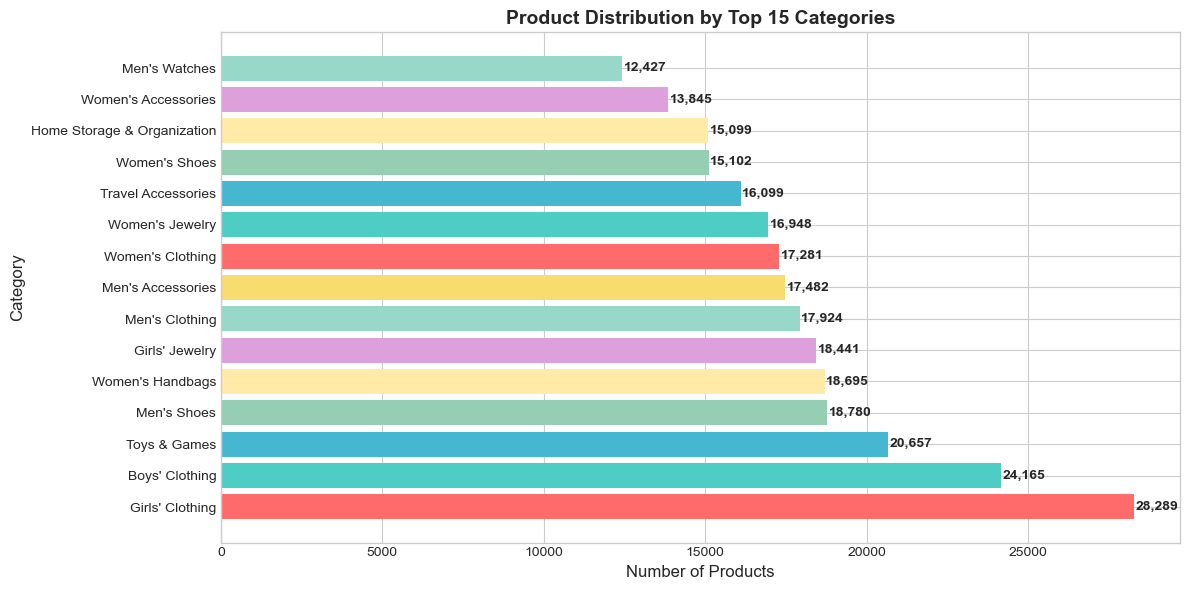


Saved: viz_category_distribution.png.
Total categories:248
Top category:Girls' Clothing (28,289 products)


In [67]:
print("Visualization 1: Category Distribution:")

fig, ax = plt.subplots(figsize=(12, 6))

category_counts = df_clean['category_name'].value_counts().head(15)
bars = ax.barh(category_counts.index, category_counts.values, color=colors[:len(category_counts)])

ax.set_xlabel('Number of Products', fontsize=12)
ax.set_ylabel('Category', fontsize=12)
ax.set_title('Product Distribution by Top 15 Categories', fontsize=14, fontweight='bold')

# Add value labels
for bar, count in zip(bars, category_counts.values):
    ax.text(count + 50, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('viz_category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: viz_category_distribution.png.")
print(f"Total categories:{df_clean['category_name'].nunique()}")
print(f"Top category:{category_counts.index[0]} ({category_counts.values[0]:,} products)")

Visualization 2: Price Distribution:


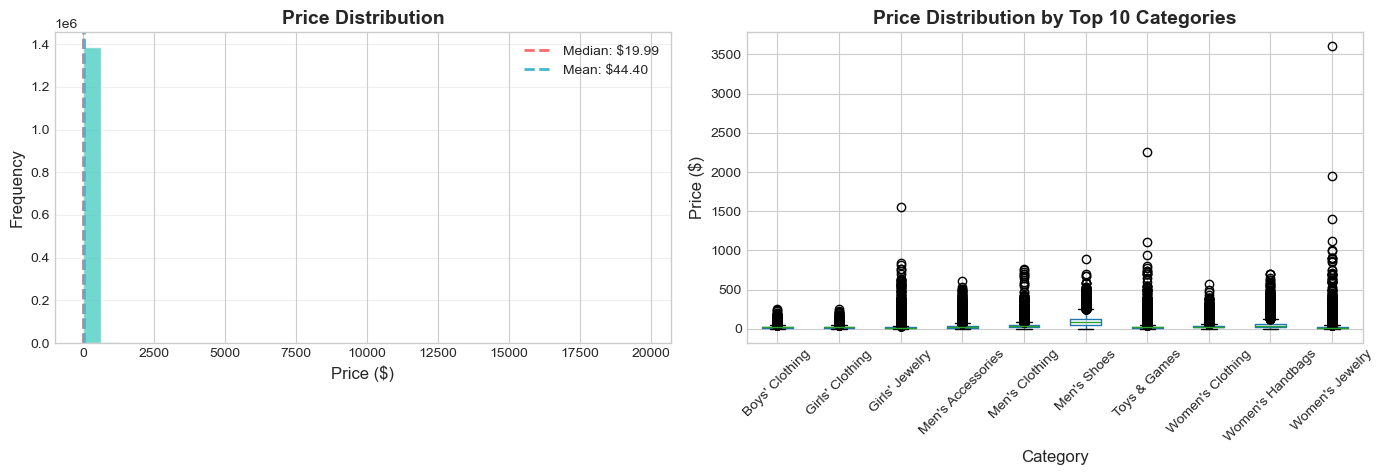


Saved: viz_price_distribution.png
Price range:$0.01 - $19731.81
Median price:$19.99
Mean price:$44.40
Left: Majority of products under $100, heavily right-skewed distribution.
Right: Price varies significantly by category.


In [68]:
print("Visualization 2: Price Distribution:")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Histogram
axes[0].hist(df_clean['price'], bins=30, color='#4ECDC4', edgecolor='white', alpha=0.8)
axes[0].axvline(df_clean['price'].median(), color='#FF6B6B', linestyle='--', linewidth=2,
                label=f'Median: ${df_clean["price"].median():.2f}')
axes[0].axvline(df_clean['price'].mean(), color='#45B7D1', linestyle='--', linewidth=2,
                label=f'Mean: ${df_clean["price"].mean():.2f}')
axes[0].set_xlabel('Price ($)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Price Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Right: Box plot by Top 10 categories only
top_10_categories = df_clean['category_name'].value_counts().head(10).index
df_top = df_clean[df_clean['category_name'].isin(top_10_categories)]
df_top.boxplot(column='price', by='category_name', ax=axes[1], rot=45)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Price ($)', fontsize=12)
axes[1].set_title('Price Distribution by Top 10 Categories', fontsize=14, fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.savefig('viz_price_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: viz_price_distribution.png")
print(f"Price range:${df_clean['price'].min():.2f} - ${df_clean['price'].max():.2f}")
print(f"Median price:${df_clean['price'].median():.2f}")
print(f"Mean price:${df_clean['price'].mean():.2f}")
print("Left: Majority of products under $100, heavily right-skewed distribution.")
print("Right: Price varies significantly by category.")

Visualization 3: Word Cloud of Product Descriptions:


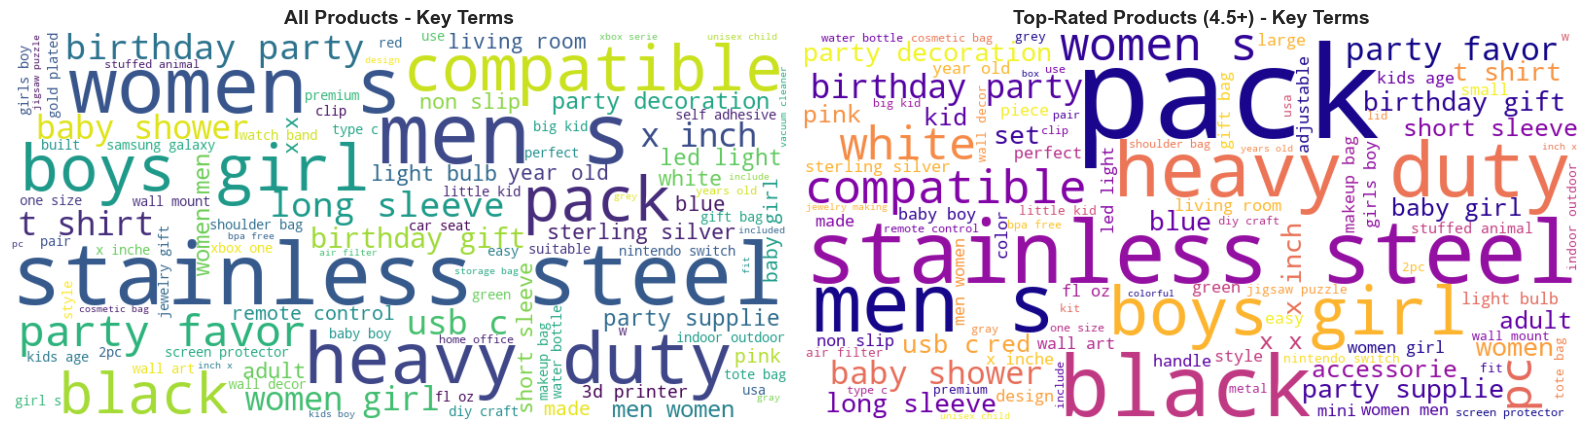

Left: Common terms across all products - useful for search suggestions.
Right: Terms in top-rated products - can highlight quality indicators in UI.


In [69]:
print("Visualization 3: Word Cloud of Product Descriptions:")
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# All products word cloud
all_text = ' '.join(df_clean['combined_text'].tolist())
wordcloud_all = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='viridis',
    max_words=100
).generate(all_text)

axes[0].imshow(wordcloud_all, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title('All Products - Key Terms', fontsize=14, fontweight='bold')

# Top-rated products word cloud
top_rated = df_clean[df_clean['rating'] >= 4.5]
top_text = ' '.join(top_rated['combined_text'].tolist())
wordcloud_top = WordCloud(
    width=800, height=400,
    background_color='white',
    colormap='plasma',
    max_words=100
).generate(top_text)

axes[1].imshow(wordcloud_top, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title('Top-Rated Products (4.5+) - Key Terms', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('viz_wordcloud.png', dpi=150, bbox_inches='tight')
plt.show()

print("Left: Common terms across all products - useful for search suggestions.")
print("Right: Terms in top-rated products - can highlight quality indicators in UI.")

Visualization 4: Category-Price Heatmap:


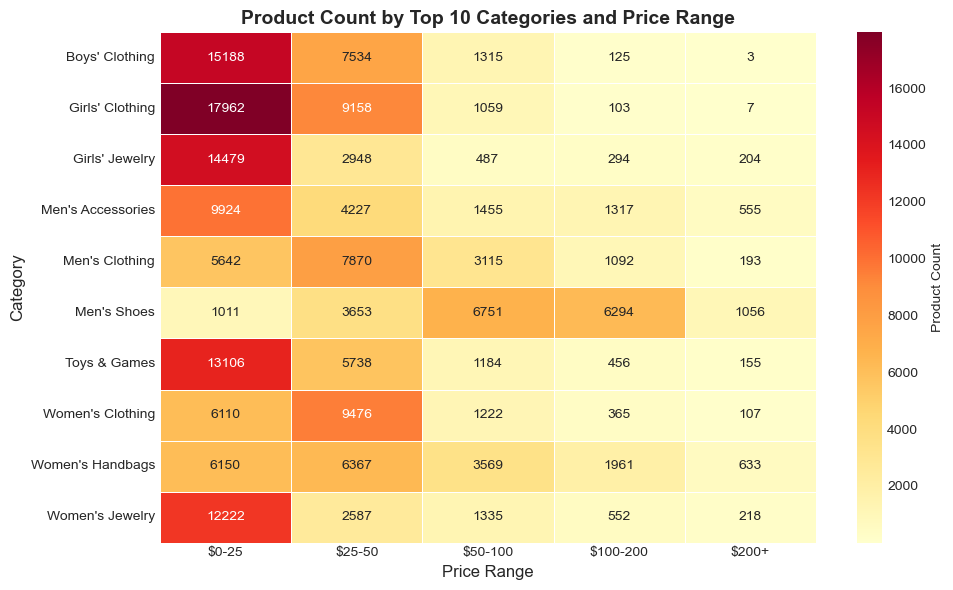


Saved: viz_category_price_heatmap.png
Shows product availability at different price points for top categories.


In [70]:
print("Visualization 4: Category-Price Heatmap:")

fig, ax = plt.subplots(figsize=(10, 6))

# Create price bins
price_bins = [0, 25, 50, 100, 200, 500]
price_labels = ['$0-25', '$25-50', '$50-100', '$100-200', '$200+']
df_clean['price_range'] = pd.cut(df_clean['price'], bins=price_bins, labels=price_labels)

# Get the Top 10 categories
top_10_cats = df_clean['category_name'].value_counts().head(10).index
df_top = df_clean[df_clean['category_name'].isin(top_10_cats)]

heatmap_data = pd.crosstab(df_top['category_name'], df_top['price_range'])

sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', ax=ax, 
            cbar_kws={'label': 'Product Count'}, linewidths=0.5)
ax.set_xlabel('Price Range', fontsize=12)
ax.set_ylabel('Category', fontsize=12)
ax.set_title('Product Count by Top 10 Categories and Price Range', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('viz_category_price_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: viz_category_price_heatmap.png")
print("Shows product availability at different price points for top categories.")

Visualization 5: Recommendation Scores Comparison:


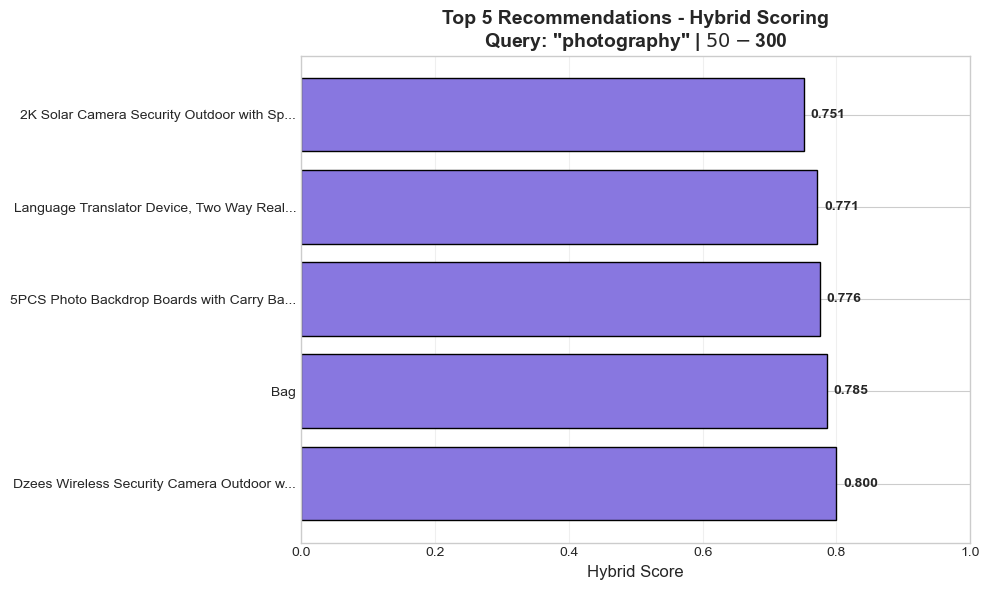


Saved: viz_recommendation_scores.png
Shows how the hybrid model scores and ranks recommendations.


In [71]:
print("Visualization 5: Recommendation Scores Comparison:")
# Get recommendations from hybrid model
sample_recs = hybrid_recommender("photography", 50, 300, top_n=5)

fig, ax = plt.subplots(figsize=(10, 6))

# Truncate titles for readability
titles = [title[:40] + '...' if len(title) > 40 else title for title in sample_recs['title']]
scores = sample_recs['hybrid_score']

bars = ax.barh(range(len(titles)), scores, color="#8877E0", edgecolor='black', linewidth=1)

# Add score labels
for i, (bar, score) in enumerate(zip(bars, scores)):
    ax.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{score:.3f}', va='center', fontweight='bold')

ax.set_yticks(range(len(titles)))
ax.set_yticklabels(titles, fontsize=10)
ax.set_xlabel('Hybrid Score', fontsize=12)
ax.set_title('Top 5 Recommendations - Hybrid Scoring\nQuery: "photography" | $50-$300', 
             fontsize=14, fontweight='bold')
ax.set_xlim(0, 1.0)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('viz_recommendation_scores.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSaved: viz_recommendation_scores.png")
print("Shows how the hybrid model scores and ranks recommendations.")

## 5: JSON Outputs for SE Integration

In [72]:
def generate_api_response(interest, min_price, max_price, top_n=10, model='hybrid'):
    """
    Generate API-ready JSON response for recommendations.
    
    Parameters:
    -----------
    interest : str
        User's interest query
    min_price : float
        Minimum price filter
    max_price : float
        Maximum price filter
    top_n : int
        Number of recommendations
    model : str
        Model to use ('baseline', 'enhanced', 'hybrid')
    
    Returns:
    --------
    dict: API response structure
    """
    # Get recommendations based on model
    if model == 'baseline':
        recs = baseline_recommender(interest, min_price, max_price, top_n=top_n)
        score_col = 'similarity_score'
    elif model == 'enhanced':
        recs = enhanced_recommender(interest, min_price, max_price, top_n=top_n)
        score_col = 'final_score'
    else:
        recs = hybrid_recommender(interest, min_price, max_price, top_n=top_n)
        score_col = 'hybrid_score'
    
    # Build response structure
    response = {
        "status": "success",
        "query": {
            "interest": interest,
            "price_range": {
                "min": float(min_price),
                "max": float(max_price)
            },
            "model_used": model
        },
        "results_count": len(recs),
        "recommendations": []}
    
    # Add each recommendation
    for idx, row in recs.iterrows():
        rec_item = {
            "rank": len(response['recommendations']) + 1,
            "product_id": str(row.get('asin', f'PROD_{idx}')),  # Use asin, not product_id
            "title": str(row['title']),
            "category": str(row.get('category_name', 'N/A')),  # category_name, not main_category
            "price": round(float(row['price']), 2),
            "rating": round(float(row['rating']), 1),
            "review_count": int(row.get('review_count', 0)),
            "relevance_score": round(float(row[score_col]), 4),
            "confidence": "high" if row[score_col] >= 0.7 else "medium" if row[score_col] >= 0.5 else "low"}
        
        response['recommendations'].append(rec_item)
    
    return response

print("API response generator defined.")

API response generator defined.


In [73]:
# Generate sample API response
print("Sample API Response:")

api_response = generate_api_response(interest="cooking kitchen chef", min_price=30, max_price=150, top_n=5, model='hybrid')

print(json.dumps(api_response, indent=2))

# Save to file
with open('sample_api_response.json', 'w') as f:
    json.dump(api_response, f, indent=2)

print("\nSaved to 'sample_api_response.json'")

Sample API Response:
{
  "status": "success",
  "query": {
    "interest": "cooking kitchen chef",
    "price_range": {
      "min": 30.0,
      "max": 150.0
    },
    "model_used": "hybrid"
  },
  "results_count": 5,
  "recommendations": [
    {
      "rank": 1,
      "product_id": "PROD_0",
      "title": "Opinel Le Petit Chef Knife Set, Chef Knife with Rounded Tip, Fingers Guard, For Children, Teaching Food Prep and Kitchen Safety, 2 Piece Set, Made in France",
      "category": "N/A",
      "price": 36.0,
      "rating": 4.7,
      "review_count": 967,
      "relevance_score": 0.8205,
      "confidence": "high"
    },
    {
      "rank": 2,
      "product_id": "PROD_1",
      "title": "Global 8\" Chef's Knife",
      "category": "N/A",
      "price": 65.0,
      "rating": 4.7,
      "review_count": 0,
      "relevance_score": 0.7528,
      "confidence": "high"
    },
    {
      "rank": 3,
      "product_id": "PROD_2",
      "title": "CARTMAN 148 Piece Automotive and Household Too

In [74]:
# Generate category metadata JSON
category_stats = df_clean.groupby('category_name').agg({'asin': 'count', 'price': ['min', 'max', 'mean', 'median'], 'rating': 'mean'}).round(2)

category_stats.columns = ['product_count', 'min_price', 'max_price', 'avg_price', 'median_price', 'avg_rating']
category_stats = category_stats.reset_index()

category_metadata = {
    "total_categories": len(category_stats),
    "generated_at": pd.Timestamp.now().isoformat(),
    "categories": []}

for _, row in category_stats.iterrows():
    category_metadata['categories'].append({
        "name": row['category_name'],
        "product_count": int(row['product_count']),
        "price_range": {
            "min": float(row['min_price']),
            "max": float(row['max_price']),
            "average": float(row['avg_price']),
            "median": float(row['median_price'])},
        "average_rating": float(row['avg_rating']),
        "suggested_budgets": {
            "low": round(row['median_price'] * 0.5, 2),
            "medium": round(row['median_price'], 2),
            "high": round(row['median_price'] * 2, 2)}})

print(f"\nGenerated metadata for {len(category_stats)} categories.")
print("\nSample (first 3 categories):")
print(json.dumps({"categories": category_metadata['categories'][:3]}, indent=2))

# Save to file
with open('category_metadata.json', 'w') as f:
    json.dump(category_metadata, f, indent=2)

print("\nSaved to 'category_metadata.json'")


Generated metadata for 248 categories.

Sample (first 3 categories):
{
  "categories": [
    {
      "name": "Abrasive & Finishing Products",
      "product_count": 8554,
      "price_range": {
        "min": 0.32,
        "max": 2550.0,
        "average": 24.65,
        "median": 14.99
      },
      "average_rating": 3.48,
      "suggested_budgets": {
        "low": 7.5,
        "medium": 14.99,
        "high": 29.98
      }
    },
    {
      "name": "Accessories & Supplies",
      "product_count": 4174,
      "price_range": {
        "min": 1.04,
        "max": 1399.97,
        "average": 40.88,
        "median": 18.98
      },
      "average_rating": 4.42,
      "suggested_budgets": {
        "low": 9.49,
        "medium": 18.98,
        "high": 37.96
      }
    },
    {
      "name": "Additive Manufacturing Products",
      "product_count": 7577,
      "price_range": {
        "min": 2.9,
        "max": 9009.0,
        "average": 53.96,
        "median": 19.54
      },
      "a

In [75]:
from collections import Counter
# Extract common keywords from product titles
all_words = ' '.join(df_clean['title_clean']).split()

# Filter out common words and keep meaningful terms
stop_words = {'for', 'with', 'and', 'the', 'set', 'pack', 'new', 'free', 'size', 
              'color', 'made', 'inch', 'usa', 'use', 'fit', 'best', 'top'}

meaningful_words = [word for word in all_words 
                    if len(word) > 3 and word not in stop_words]

word_counts = Counter(meaningful_words)
top_interests = word_counts.most_common(20)

interest_suggestions = {
    "data_driven_interests": [
        {"keyword": keyword, "frequency": count}
        for keyword, count in top_interests
    ],
    "curated_gift_themes": [
        {"theme": "Tech Enthusiast", "keywords": ["camera", "wireless", "headphones", "gaming", "smart"]},
        {"theme": "Fitness Lover", "keywords": ["yoga", "fitness", "exercise", "sports", "workout"]},
        {"theme": "Fashion Forward", "keywords": ["clothing", "jewelry", "handbag", "accessories", "shoes"]},
        {"theme": "Home Chef", "keywords": ["kitchen", "cooking", "stainless", "steel", "utensil"]},
        {"theme": "Kids & Family", "keywords": ["boys", "girls", "baby", "toddler", "kids"]},
        {"theme": "Party Planner", "keywords": ["party", "birthday", "decoration", "gift", "celebration"]}
    ],
    "search_examples": [
        "photography camera professional",
        "fitness yoga home workout",
        "gaming accessories headset",
        "cooking kitchen chef tools",
        "baby shower gifts",
        "birthday party decorations"]}

print("\nTop 20 Popular Keywords:")
for keyword, count in top_interests:
    print(f"   {keyword:20s} - {count:,} mentions")

print(f"\nGenerated {len(interest_suggestions['curated_gift_themes'])} curated themes")

# Save to file
with open('interest_suggestions.json', 'w') as f:
    json.dump(interest_suggestions, f, indent=2)

print("\nSaved to 'interest_suggestions.json'")


Top 20 Popular Keywords:
   black                - 137,240 mentions
   women                - 136,323 mentions
   kids                 - 126,200 mentions
   girls                - 106,979 mentions
   baby                 - 99,767 mentions
   party                - 77,616 mentions
   white                - 77,387 mentions
   boys                 - 68,840 mentions
   light                - 68,670 mentions
   gift                 - 68,622 mentions
   compatible           - 67,735 mentions
   toys                 - 63,475 mentions
   replacement          - 62,721 mentions
   steel                - 55,708 mentions
   case                 - 54,403 mentions
   birthday             - 54,053 mentions
   travel               - 50,506 mentions
   wall                 - 50,190 mentions
   cover                - 50,176 mentions
   gifts                - 49,317 mentions

Generated 6 curated themes

Saved to 'interest_suggestions.json'


In [76]:
print("Filtering to Available Products Only:")

# Load availability data
availability = pd.read_csv('amazon_availability_final.csv')
print(f"Loaded {len(availability):,} product availability records.")

# Check what columns it has
print(f"\nColumns: {availability.columns.tolist()}")

# Show first few rows
print("\nSample data:")
print(availability.head())

# Check availability status counts
if 'available' in availability.columns:
    print(f"\nAvailability counts:")
    print(availability['available'].value_counts())
elif 'is_available' in availability.columns:
    print(f"\nAvailability counts:")
    print(availability['is_available'].value_counts())

Filtering to Available Products Only:
Loaded 1,426,336 product availability records.

Columns: ['asin', 'title', 'imgUrl', 'productURL', 'stars', 'reviews', 'price', 'listPrice', 'isBestSeller', 'boughtInLastMonth', 'category_name', 'broad_category', 'availability']

Sample data:
         asin                                              title  \
0  B014TMV5YE  Sion Softside Expandable Roller Luggage, Black...   
1  B07GDLCQXV  Luggage Sets Expandable PC+ABS Durable Suitcas...   
2  B07XSCCZYG  Platinum Elite Softside Expandable Checked Lug...   
3  B08MVFKGJM  Freeform Hardside Expandable with Double Spinn...   
4  B01DJLKZBA  Winfield 2 Hardside Expandable Luggage with Sp...   

                                              imgUrl  \
0  https://m.media-amazon.com/images/I/815dLQKYIY...   
1  https://m.media-amazon.com/images/I/81bQlm7vf6...   
2  https://m.media-amazon.com/images/I/71EA35zvJB...   
3  https://m.media-amazon.com/images/I/91k6NYLQyI...   
4  https://m.media-amazon.com/

In [77]:
# Check availability values
print("Availability status counts:")
print(availability['availability'].value_counts())

# Filter to only available products
available_products = availability[availability['availability'] == 'available']
print(f"\nAvailable products: {len(available_products):,}")
print(f"Unavailable products: {len(availability) - len(available_products):,}")

# Now merge with your df_clean
print("\nMerging with cleaned dataset:")
initial_count = len(df_clean)

# Merge on asin to keep only available products
df_clean = df_clean.merge(available_products[['asin', 'availability']], on='asin', how='inner')

print(f"\nDataset before filter: {initial_count:,} products")
print(f"Dataset after filter: {len(df_clean):,} products")
print(f"Removed: {initial_count - len(df_clean):,} unavailable products")

# Drop the availability column
df_clean = df_clean.drop('availability', axis=1)
print("\nDataset now contains only available products.")

Availability status counts:
availability
available      1318867
unavailable     107469
Name: count, dtype: int64

Available products: 1,318,867
Unavailable products: 107,469

Merging with cleaned dataset:

Dataset before filter: 1,393,565 products
Dataset after filter: 1,288,336 products
Removed: 105,229 unavailable products

Dataset now contains only available products.


In [78]:
print("Regerating Sample with Available Products:")

# Use a sample for embeddings (50,000 available products)
df_sample = df_clean.sample(n=50000, random_state=42).reset_index(drop=True)
print(f"Using {len(df_sample):,} available products for models")

# Regenerate embeddings
print("\nGenerating product embeddings:")
product_embeddings = sentence_model.encode(
    df_sample['combined_text'].tolist(),
    show_progress_bar=True,
    convert_to_numpy=True)

print(f"\nEmbeddings generated:{product_embeddings.shape}")
print("All models now use only available products.")

Regerating Sample with Available Products:
Using 50,000 available products for models

Generating product embeddings:


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]


Embeddings generated:(50000, 384)
All models now use only available products.


In [ ]:
# Read the FastAPI files to see what they do
import os

print("=== main.py ===")
with open('scripts/main.py', 'r') as f:
    print(f.read())

print("\n=== data_loader.py ===")
with open('scripts/data_loader.py', 'r') as f:
    print(f.read())

print("\n=== ds_functions.py ===")
with open('scripts/ds_functions.py', 'r') as f:
    print(f.read())

print("\n=== requirements.txt ===")
with open('scripts/requirements.txt', 'r') as f:
    print(f.read())

❌ main.py
❌ data_loader.py
❌ ds_functions.py
❌ requirements.txt
